# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & \pi & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 25 # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = 1e-1 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, tol=0,
                      on_iteration=on_iteration, u_min=torch.tensor([-2.0]), u_max=torch.tensor([2.0]))


iteration 1 accepted 25.31931 [-0.18392883  0.0920998   2.076914   -0.02477717]
iteration 2 accepted 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 3 FAILED 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 4 FAILED 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 5 FAILED 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 6 FAILED 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 7 FAILED 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 8 FAILED 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 9 FAILED 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 10 FAILED 25.015944 [-0.2092468   0.04578057  2.2834694   0.4771366 ]
iteration 11 accepted 25.015049 [-0.20915496  0.0461967   2.2854517   0.48275304]
iteration 12 accepted 25.01368 [-0.20897797  0.04703692  2.289399    0.49412322]
iteration 13 FAILED 25.01368 [-0.20897797  

iteration 104 FAILED 22.753376 [-0.07353474  0.19954464  3.0773394   0.8877624 ]
iteration 105 FAILED 22.753376 [-0.07353474  0.19954464  3.0773394   0.8877624 ]
iteration 106 accepted 22.752745 [-0.07315809  0.20086452  3.0785353   0.88902354]
iteration 107 accepted 22.75274 [-0.07314309  0.20092404  3.0785909   0.8890941 ]
iteration 108 FAILED 22.75274 [-0.07314309  0.20092404  3.0785909   0.8890941 ]
iteration 109 FAILED 22.75274 [-0.07314309  0.20092404  3.0785909   0.8890941 ]
iteration 110 accepted 22.752356 [-0.07277738  0.2022351   3.0798051   0.8904699 ]
iteration 111 FAILED 22.752356 [-0.07277738  0.2022351   3.0798051   0.8904699 ]
iteration 112 accepted 22.75215 [-0.07259935  0.20288192  3.0804117   0.8911387 ]
iteration 113 FAILED 22.75215 [-0.07259935  0.20288192  3.0804117   0.8911387 ]
iteration 114 accepted 22.752022 [-0.07242426  0.20352662  3.081024    0.8918437 ]
iteration 115 FAILED 22.752022 [-0.07242426  0.20352662  3.081024    0.8918437 ]
iteration 116 accepted 

/Users/anass/Dev/personal/pddp/pddp/controllers/ilqr.py:241: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


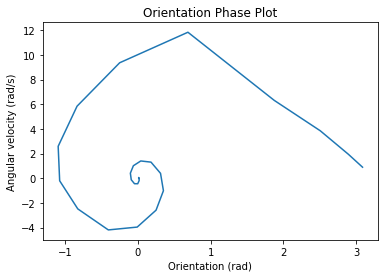

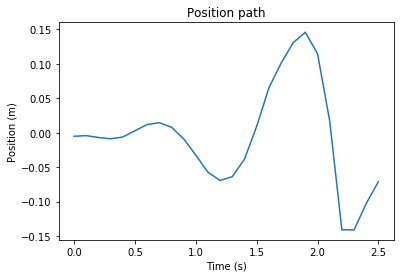

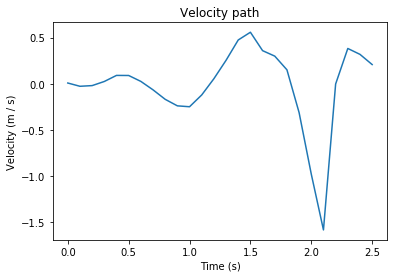

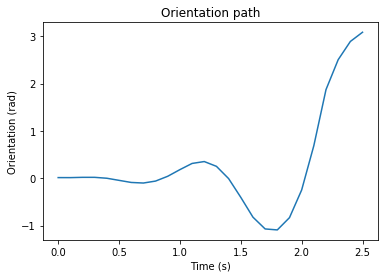

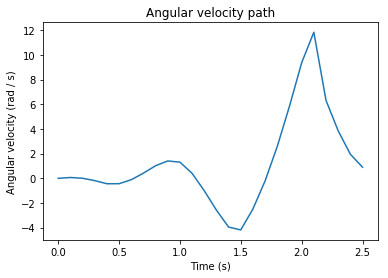

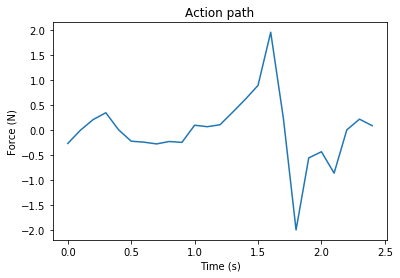

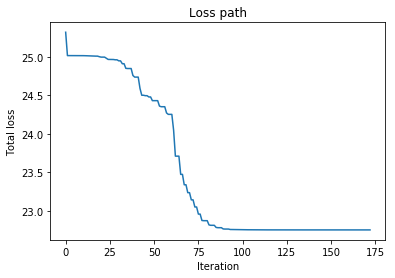

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
for u in U:
    env.apply(u)

In [16]:
env.close()